In [53]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *

## First load a few images to identify ROIs and check threshold

In [19]:
data = SFDataFiles('/sf/alvra/data/p18938/raw/XES_jet/run_008431*')
nframes = 10
threshold_low = 5

# Choose a pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals) 
# if you do not want to use the closest in time

# pedestal_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
pedestal_file = None

##################################################################
clock = Clock()
total = 0
total_thr = 0
ch_JF = data['JF02T09V02']
images = ch_JF.data[:nframes]

print ('Loaded {} images'.format(images.shape[0]))

for i in range(nframes):
    single_image = images[i, :]
    image_thr = single_image.copy()
    image_thr[single_image < threshold_low] = 0
    total_thr += image_thr
    total += single_image
    #total /= nframes

print ("It took", clock.tick(), "seconds to process this file")

KeyError: 'JF02T09V02'

<IPython.core.display.Javascript object>


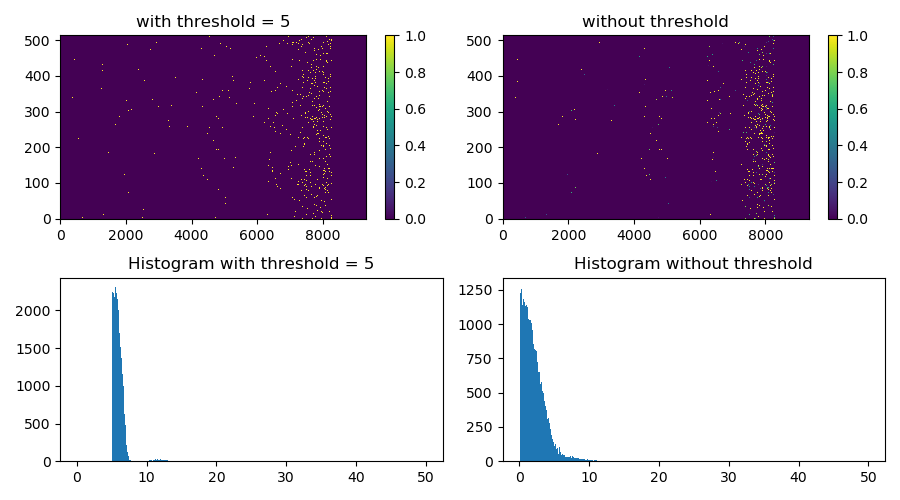

In [12]:
plt.figure(figsize=(9,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(221)
plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()
plt.subplot(222)
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("without threshold")
plt.colorbar()
plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total.ravel(), bins=np.arange(0.1,50,0.1))
plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_thr.ravel(), bins=np.arange(0.1,50,0.1))
plt.tight_layout()
plt.show()

## Next cells for a single file, ONLY JF file!

In [51]:
datalist = []
for file in glob('/sf/alvra/data/p18938/raw/XES_jet/*.JF*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist[468:493] + datalist[494:]
patch

['/sf/alvra/data/p18938/raw/XES_jet/run_008899.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008900.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008901.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008902.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008903.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008904.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008905.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008906.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008907.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008908.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008909.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008910.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008911.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008912.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008913.JF02T09V02.h5',
 '/sf/alvra/data/p18938/raw/XES_jet/run_008914.JF02T09V

In [22]:
DIR = '/sf/alvra/data/p18938/raw/XES_jet/'
run = 'run_008899'

In [52]:
roi1 = (7740, 7900, 220, 300) #signal 1
roi2 = (7740, 7900, 400, 480) #bkg 1

roi3 = (5080, 5220, 180, 280) #signal 2
roi4 = (5080, 5220, 300, 400) #bkg 2

threshold_low = 5

######################################################################################
clock = Clock()
#JF_single_file = DIR + run + '.JF02T09V02.h5'

spectrum_roi1 = 0
spectrum_roi2 = 0
spectrum_roi3 = 0
spectrum_roi4 = 0

for JF_single_file in patch:

    print("Processing file %s" % (JF_single_file))
    clear_output(wait=True)
    nshots = None
    images_roi1, images_roi2, images_roi3, images_roi4, pids = \
        load_crop_JF_batches(JF_single_file, roi1, roi2, roi3, roi4, nshots=nshots)
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    #images_roi1_thr[images_roi1 > threshold_high] = 0
    
    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    #images_roi2_thr[images_roi2 > threshold_high] = 0
    
    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    #images_roi3_thr[images_roi3 > threshold_high] = 0
    
    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    #images_roi4_thr[images_roi4 > threshold_high] = 0
    
    
    spectrum_roi1  += images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  += images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  += images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  += images_roi4_thr.sum(axis = 1).sum(axis = 0)

    print ("It took", clock.tick(), "seconds to process this file")

print ("It took", clock.tock(), "seconds to process {} files".format(len(patch)))

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_008336.JF02T09V02.res.h5
jungfrau file: 13:58 26.02.2021
pedestal file: 20:10 25.02.2021
    mtime difference: 17:48:10.079563
Total images = 760, load them in batches of 1000
Load batch = slice(0, 760, None)
It took 10.8 seconds to process this file
It took 810.3 seconds to process 34 files


<IPython.core.display.Javascript object>


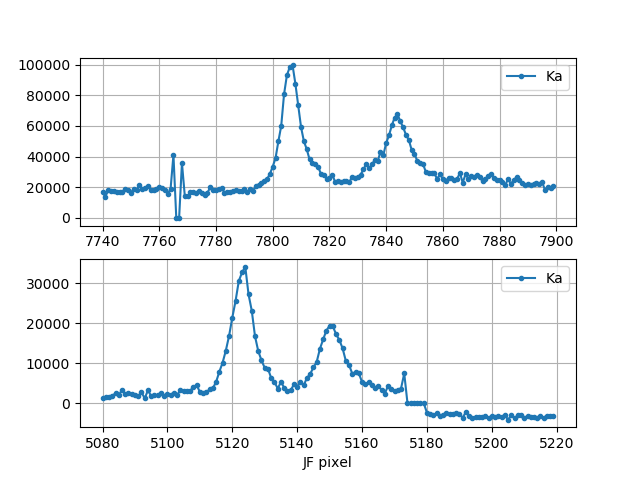

In [54]:
spectrum_bkg_roi1 = spectrum_roi1  - spectrum_roi2
err_spectrum_ro1 = np.sqrt(spectrum_roi1)
err_bkg_2 = np.sqrt(spectrum_roi2)

spectrum_bkg_roi3 = spectrum_roi3 - spectrum_roi4
err_spectrum_roi3 = np.sqrt(spectrum_roi3)
err_bkg_4 = np.sqrt(spectrum_roi4)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)
plt.xlabel("JF pixel")
plt.show()

## Next cells for a single file, any channel (BSDATA & JF) 

In [55]:
# Choose a pedestal file (usually located in /sf/alvra/data/*pgroup*/raw/JF_pedestals) 
# if you do not want to use the closest in time
# If 'None' the closest in time is selected

# pedestal_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
pedestal_file = None

In [57]:
data = SFDataFiles('/sf/alvra/data/p18938/raw/XES_jet/run_008899*')

channel_list = [channel_PIPS_fluo, channel_Izero117, 'JF02T09V02']

roi1 = (7740, 7880, 290, 340) #signal 1
roi2 = (7740, 7880, 385, 435) #bkg 1

roi3 = (5080, 5220, 210, 250) #signal 2
roi4 = (5080, 5220, 145, 185) #bkg 2

threshold_low = 5

##########################################################
clock = Clock()
spectrum_roi1 = 0
spectrum_roi2 = 0
spectrum_roi3 = 0
spectrum_roi4 = 0
print (data.fnames[0])

results = load_data_compact_JF(channel_list, data, roi1, roi2, roi3, roi4)

data.close()

Data_fluo = results[channel_PIPS_fluo]
images_roi1 = results['JFroi1']
images_roi2 = results['JFroi2']
images_roi3 = results['JFroi3']
images_roi4 = results['JFroi4']

images_roi1_thr = images_roi1.copy()
images_roi1_thr[images_roi1 < threshold_low] = 0
#images_roi1_thr[images_roi1 > threshold_high] = 0

images_roi2_thr = images_roi2.copy()
images_roi2_thr[images_roi2 < threshold_low] = 0
#images_roi2_thr[images_roi2 > threshold_high] = 0

images_roi3_thr = images_roi3.copy()
images_roi3_thr[images_roi3 < threshold_low] = 0
#images_roi3_thr[images_roi3 > threshold_high] = 0

images_roi4_thr = images_roi4.copy()
images_roi4_thr[images_roi4 < threshold_low] = 0
#images_roi4_thr[images_roi4 > threshold_high] = 0

spectrum_roi1 = images_roi1_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi2 = images_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi3 = images_roi3_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi4 = images_roi4_thr.sum(axis = 1).sum(axis = 0)

print ("It took", clock.tick(), "seconds to process this file")

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_008336.JF02T09V02.res.h5
jungfrau file: 13:14 26.02.2021
pedestal file: 20:10 25.02.2021
    mtime difference: 17:03:54.322510
/sf/alvra/data/p18938/raw/XES_jet/run_008899.BSDATA.h5

--------------------------------------------------------------------------------

JF02T09V02                2000 / 8000 -> 75% loss ▇▇
SAR-CVME-TIFALL5:EvtSet   8000 / 8000 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  2000 / 8000 -> 75% loss ▇▇
SAROP11-PBPS117:INTENSITY 1987 / 8000 -> 75% loss ▇▇

over the whole data set: 1987 / 8000 -> 75% loss
complete channels: 1 / 4 -> 75% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
It took 31.59 seconds to process this file


<IPython.core.display.Javascript object>


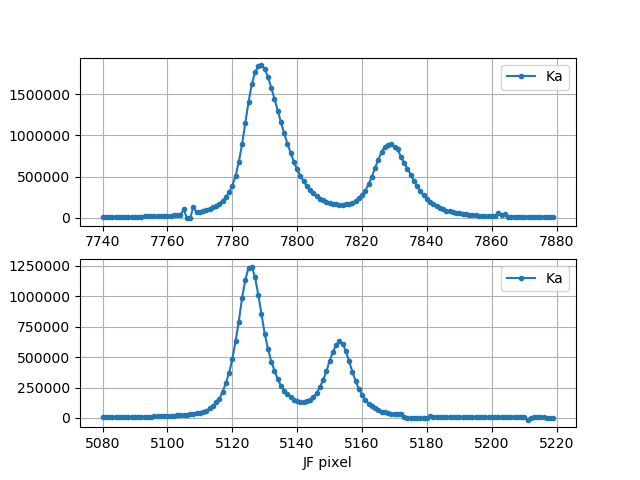

In [8]:
spectrum_bkg_roi1 = spectrum_roi1  - spectrum_roi2
err_spectrum_ro1 = np.sqrt(spectrum_roi1)
err_bkg_2 = np.sqrt(spectrum_roi2)

spectrum_bkg_roi3 = spectrum_roi3 - spectrum_roi4
err_spectrum_roi3 = np.sqrt(spectrum_roi3)
err_bkg_4 = np.sqrt(spectrum_roi4)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)
plt.xlabel("JF pixel")
plt.show()

## Next cells for scans, ONLY JF file!

In [9]:
fc = FileChooser('/sf/alvra/data/p18442/res/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18442/res/scan_info', filename='', show_hidden='False')

In [10]:

roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (2000, 2200, 10, 210)   # Lb _not set correctly!
roi4 = (2000, 2200, 230, 430)   # Kb_background

threshold_low = 2.0
threshold_high = 10

######################################################################################

json_file = fc.selected
scan_data = load_scan_data(json_file)

Energy_eV = []
Delay_mm = []
XAS_roi1 = []
XAS_roi3 = []
calibration = []
RIXS_roi1 = []
RIXS_roi3 = []

clock = Clock()
num_scan_files = len(scan_data)
print("\nProcessing", num_scan_files, "total files")

for i, (bs, fn1) in enumerate(scan_data):
#for i in range(0,4):
    clear_output(wait=True)
    
    print("\nFile", i+1, "of", num_scan_files, ": Processing:", fn1.split("/")[-1])
    
    spectrum_roi1 = 0
    spectrum_roi2 = 0
    spectrum_roi3 = 0
    spectrum_roi4 = 0
    
    #nshots = 10000  # put this to None for ALL images
    nshots = None
    
    images_roi1, images_roi2, images_roi3, images_roi4, pids = \
    load_crop_JF_batches(fn1, roi1, roi2, roi3, roi4, nshots=nshots)
    
    energy, pids = load_single_channel_pulseID(bs, channel_energy, 50)
    energy = [x for x in energy if (x > 0)]
    Energy_eV.append(np.mean(energy))
    
    delay, pids = load_single_channel_pulseID(bs, channel_delay_topas, 50)
    delay = [x for x in delay if (x > 0)]
    Delay_mm.append(np.mean(delay))
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    images_roi1_thr[images_roi1 > threshold_high] = 0

    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    images_roi2_thr[images_roi2 > threshold_high] = 0

    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    images_roi3_thr[images_roi3 > threshold_high] = 0

    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    images_roi4_thr[images_roi4 > threshold_high] = 0

    
    spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
    XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
    #print (np.argmax(spectrum_roi3 - spectrum_roi4))
    calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

    RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
    RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
    
    
    print ("It took", clock.tick(), "seconds to process this file")

Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)
XAS_roi1 = np.array(XAS_roi1)
calibration = np.array(calibration)
RIXS_roi1 = np.array(RIXS_roi1)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")


File 41 of 41 : Processing: run_000952.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18442/res/JF_pedestals/pedestal_20200131_2048.JF02T09V02.res.h5
jungfrau file: 12:55 31.01.2020
pedestal file: 20:58 31.01.2020
    mtime difference: -8:03:03.145637
Total images = 2500, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 2000, None)
Load batch = slice(2000, 2500, None)
It took 15.19 seconds to process this file

Job done! It took 649.63 seconds to process 41 file(s)


<IPython.core.display.Javascript object>


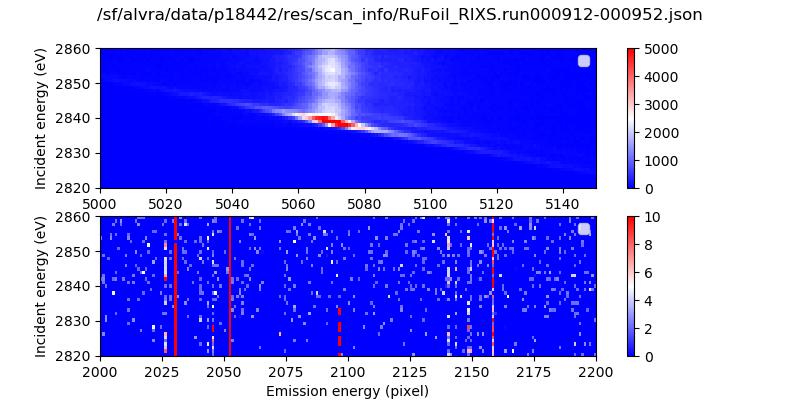

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [11]:
plt.figure(figsize=(8,4))
plt.suptitle(json_file, fontsize=12)
plt.subplot(211)
plt.imshow(RIXS_roi1, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=5000)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.imshow(RIXS_roi3, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()
plt.show()


## Next cells for an energy, any channel (BSDATA & JF) 

In [12]:
fc = FileChooser('/sf/alvra/data/p18442/res/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18442/res/scan_info', filename='', show_hidden='False')

In [13]:
channel_list = [channel_PIPS_fluo, 'JF02T09V02']

roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (2000, 2200, 10, 210)   # Lb _not set correctly!
roi4 = (2000, 2200, 230, 430)   # Kb_background


threshold_low = 2

####################################################################################################3
clock = Clock()
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

XAS_roi1 = []
XAS_roi3 = []
calibration = []
RIXS_roi1 = []
RIXS_roi3 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    spectrum_roi1 = 0
    spectrum_roi2 = 0
    spectrum_roi3 = 0
    spectrum_roi4 = 0
    
    results = load_data_compact(channel_list, step)
    
    Data_fluo = results[channel_PIPS_fluo]
    images = results['JF02T09V02']
    
    images_roi1 = crop_roi(images, roi1)
    images_roi2 = crop_roi(images, roi2)
    images_roi3 = crop_roi(images, roi3)
    images_roi4 = crop_roi(images, roi4)
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    #images_roi1_thr[images_roi1 > threshold_high] = 0
    
    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    #images_roi2_thr[images_roi2 > threshold_high] = 0
    
    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    #images_roi3_thr[images_roi3 > threshold_high] = 0
    
    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    #images_roi4_thr[images_roi4 > threshold_high] = 0
    
    spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
    XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
    #print (np.argmax(spectrum_roi3 - spectrum_roi4))
    calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

    RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
    RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
    
    print ("It took", clock.tick(), "seconds to process this file")
    
XAS_roi1 = np.array(XAS_roi1)
XAS_roi3 = np.array(XAS_roi3)

calibration = np.array(calibration)
RIXS_roi1 = np.array(RIXS_roi1)
RIXS_roi3 = np.array(RIXS_roi3)

print ("\nJob done! It took", clock.tock(), "seconds to process all the files")

Step 41 of 41: Processing run_000952

--------------------------------------------------------------------------------

JF02T09V02               2500 / 4999 -> 50% loss ▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet  4999 / 4999 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET 4999 / 4999 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2500 / 4999 -> 50% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
It took 55.7 seconds to process this file

Job done! It took 2280.56 seconds to process all the files


<IPython.core.display.Javascript object>


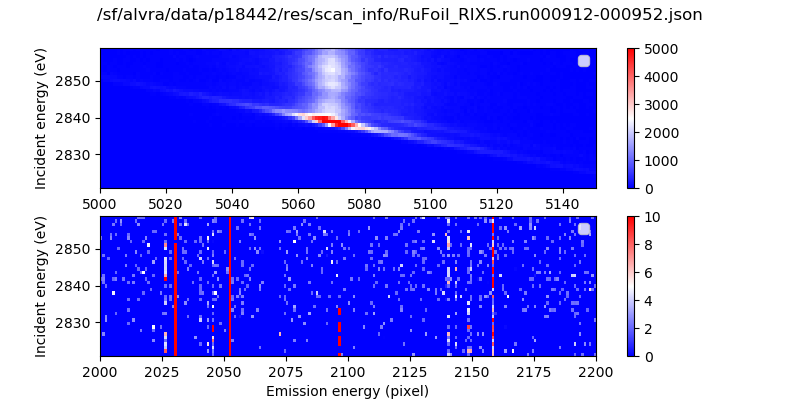

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [14]:
plt.figure(figsize=(8,4))
plt.suptitle(fc.selected, fontsize=12)
plt.subplot(211)
plt.imshow(RIXS_roi1, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=5000)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.imshow(RIXS_roi3, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


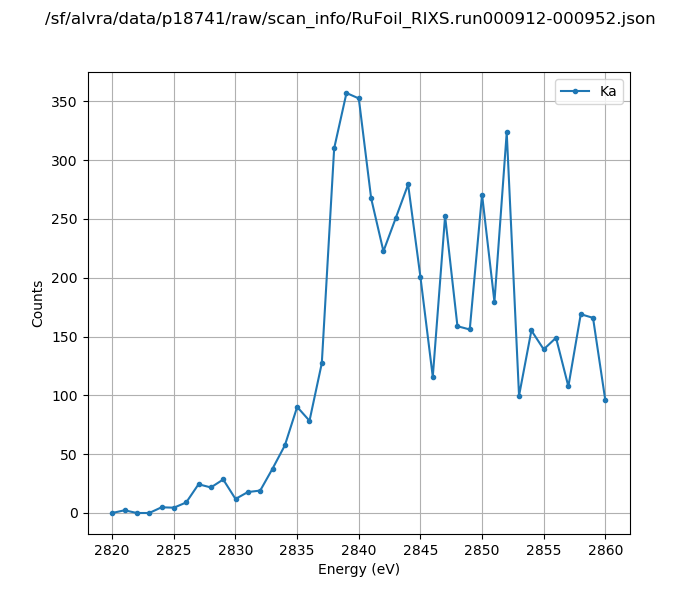

In [29]:
plt.figure(figsize=(7,6))
plt.suptitle(json_file, fontsize=12)

plt.plot(Energy_eV, XAS_roi1,label="Ka", marker='.')
plt.xlabel("Energy (eV)")
plt.ylabel("Counts")
plt.legend(loc="best")
plt.grid()

plt.show()

In [ ]:
def edge_removal(module_edge, roi_removal, array):
    index_edge = module_edge - roi_removal[0]
    array_input = array.copy()
    print (array[index_edge-1:index_edge+3])
    array[index_edge] = array[index_edge-1]/2
    array[index_edge-1] = array[index_edge-1]/2

    array[index_edge+1] = array[index_edge+2]/2
    array[index_edge+2] = array[index_edge+2]/2 
    print (array[index_edge-1:index_edge+3])
    return array, array_input

In [ ]:
spectrum_ON_roi1, spectrum_ON_roi1_orig = edge_removal(6472, roi1, spectrum_ON_roi1) 
spectrum_OFF_roi1, spectrum_OFF_roi1_orig = edge_removal(6472, roi1, spectrum_OFF_roi1) 